<a href="https://colab.research.google.com/github/annsikhwan/Counter_App1/blob/main/Brain_Tumor_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



# **Brain Tumor Classification**


---


This project trains on images of Brain MRI scans and then classifies each image into one of the following four categories:

*   Glioma Tumor
*   Meningioma Tumor
*   Pituitary Tumor
*   No Tumor


---



In [1]:
!git clone https://github.com/nazianafis/Brain-MRI-Classification.git

Cloning into 'Brain-MRI-Classification'...
remote: Enumerating objects: 3125, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 3125 (delta 29), reused 75 (delta 23), pack-reused 3042 (from 1)
Receiving objects: 100% (3125/3125), 83.50 MiB | 15.76 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Updating files: 100% (3291/3291), done.


### Import libraries

In [2]:
# Import libraries

import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils


### Create directories

In [3]:
# Create Directory for Training Data

import os

if not os.path.exists("/content/Crop-Brain-MRI"):
    os.mkdir("/content/Crop-Brain-MRI")
if not os.path.exists("/content/Crop-Brain-MRI/glioma_tumor"):
    os.mkdir("/content/Crop-Brain-MRI/glioma_tumor")
if not os.path.exists("/content/Crop-Brain-MRI/meningioma_tumor"):
    os.mkdir("/content/Crop-Brain-MRI/meningioma_tumor")
if not os.path.exists("/content/Crop-Brain-MRI/no_tumor"):
    os.mkdir("/content/Crop-Brain-MRI/no_tumor")
if not os.path.exists("/content/Crop-Brain-MRI/pituitary_tumor"):
    os.mkdir("/content/Crop-Brain-MRI/pituitary_tumor")

In [4]:
# Create Directory for Testing Data

import os

if not os.path.exists("/content/Test-Brain-MRI"):
    os.mkdir("/content/Test-Brain-MRI")
if not os.path.exists("/content/Test-Brain-MRI/glioma_tumor"):
    os.mkdir("/content/Test-Brain-MRI/glioma_tumor")
if not os.path.exists("/content/Test-Brain-MRI/meningioma_tumor"):
    os.mkdir("/content/Test-Brain-MRI/meningioma_tumor")
if not os.path.exists("/content/Test-Brain-MRI/no_tumor"):
    os.mkdir("/content/Test-Brain-MRI/no_tumor")
if not os.path.exists("/content/Test-Brain-MRI/pituitary_tumor"):
    os.mkdir("/content/Test-Brain-MRI/pituitary_tumor")

### Data Visualisation

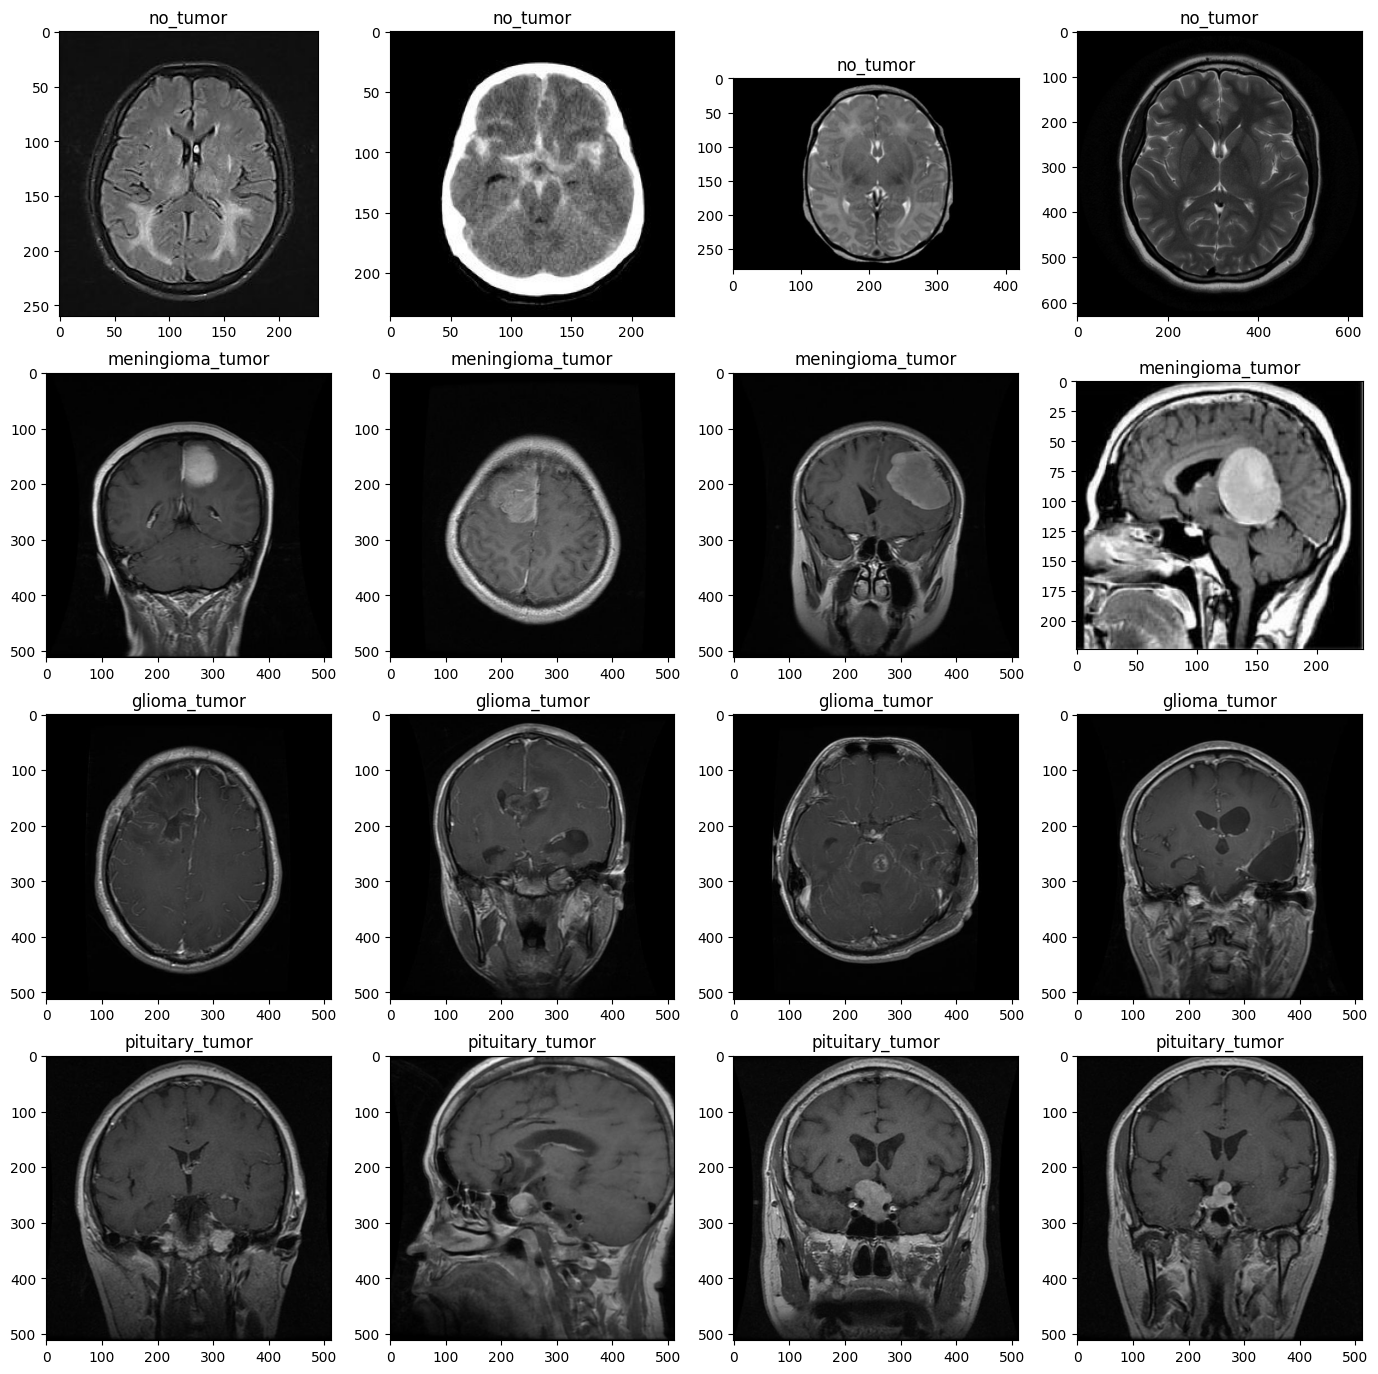

In [5]:
# Data Visualisation

train_dir = "/content/Brain-MRI-Classification/Brain-MRI/Training/"
test_dir = "/content/Brain-MRI-Classification/Brain-MRI/Testing/"

classes = os.listdir("/content/Brain-MRI-Classification/Brain-MRI/Training")

files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x :train_dir+c+'/'+x, os.listdir(train_dir+c)))

plt.figure(figsize=(17,17))
index = 0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range (1,5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)



### Crop and Save images

In [6]:
# Function to crop images

def crop_image(image, plot=False):

    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)

    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image


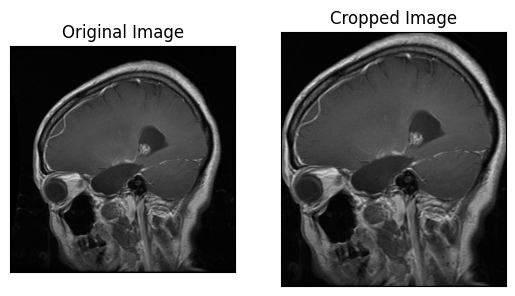

In [7]:
# Check the crop

example_img = cv2.imread("/content/Brain-MRI-Classification/Brain-MRI/Training/glioma_tumor/gg (101).jpg")
cropped_image_example = crop_image(example_img, plot=True)

In [8]:
# Crop the Training Images and Save to respective directories
glioma = train_dir + "glioma_tumor"
meningioma = train_dir + "meningioma_tumor"
no_tumor = train_dir + "no_tumor"
pituitary = train_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/glioma_tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/meningioma_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/no_tumor/"+str()+".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/pituitary_tumor/"+str()+".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1





100%|██████████| 901/901 [00:02<00:00, 316.14it/s]


In [9]:
# Crop the Testing Images and Save to respective directories
glioma = test_dir + "glioma_tumor"
meningioma = test_dir + "meningioma_tumor"
no_tumor = test_dir + "no_tumor"
pituitary = test_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Brain-MRI/glioma_tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Brain-MRI/meningioma_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Brain-MRI/no_tumor/"+str()+".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Brain-MRI/pituitary_tumor/"+str()+".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1





100%|██████████| 5/5 [00:00<00:00, 155.80it/s]


### Perform Data Augmentation and Prepare the Train, Validation, and Test Dataset

In [10]:
# Use Image Data Generator

datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/', target_size=(224,224), batch_size=32, class_mode='categorical', subset='training')

valid_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/', target_size=(224,224), batch_size=32, class_mode='categorical', subset='validation')

test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/content/Test-Brain-MRI/', target_size=(224,224), class_mode='categorical')


Found 1493 images belonging to 4 classes.
Found 372 images belonging to 4 classes.
Found 12 images belonging to 4 classes.


In [11]:
# View the class dictionary

print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


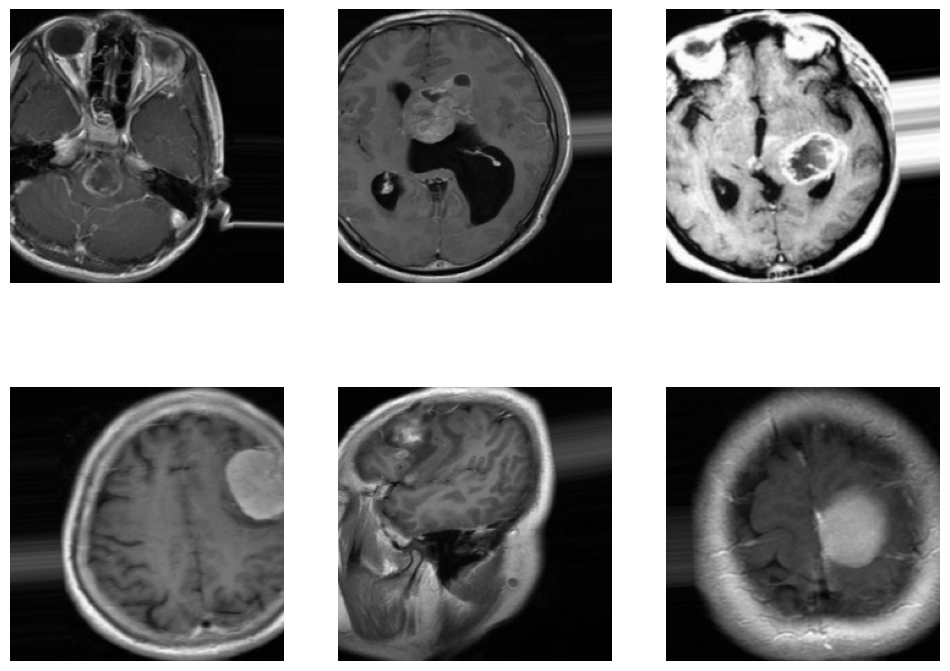

In [12]:
# View the augmented data

sample_x, sample_y =next(train_data)
plt.figure(figsize=(12,9))
for i in range (6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()


### Build and Compile the model

In [13]:
# Build the Model

effnet = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224,224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= effnet.input, outputs=model)

model.summary()

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 6,580,363 (25.10 MB)

 Trainable params: 6,518,308 (24.87 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [14]:
# Compile the model

model.compile(optimizer=Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto", verbose=1)

### Train and Evaluate the model

In [ ]:
# Train the model

history = model.fit(train_data, epochs=7, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystop])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
33/47 ━━━━━━━━━━━━━━━━━━━━ 6s 449ms/step - accuracy: 0.3906 - loss: 1.3109

In [ ]:
# Plot the training curves

plt.style.use("ggplot")
plt.figure(figsize=(12,6))
epochs = range(1,8)
plt.subplot(1,2,1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","Validate"], loc="upper left")

plt.subplot(1,2,2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","Validate"], loc="upper left")

plt.show()

In [ ]:
# Evaluate the model on Test Set

model.evaluate(test_data)

### Obtain Predictions

In [ ]:
# Obtain Prediction on Test Image

class_dict = {0: "glioma_tumor", 1: "meningioma_tumor", 2: "no_tumor", 3: "pituitary_tumor"}

test_img1 = cv2.imread("/content/Test-Brain-MRI/meningioma_tumor/4.jpg")

plt.imshow(test_img1)

plt.grid(False)

test_img1 = np.expand_dims(test_img1, axis=0)

pred = model.predict(test_img1)
pred = np.argmax(pred)
pred_class =class_dict[pred]
print(pred_class)